# **Pre-processing**

In [ ]:
import re
import requests
import pandas as pd
from pprint import pprint
from opencc import OpenCC
from datetime import datetime
from html.parser import HTMLParser

# **Build function**

In [ ]:
class YoutubeSpider():
    def __init__(self, api_key):
        self.base_url = "https://www.googleapis.com/youtube/v3/"
        self.api_key = api_key

    def get_html_to_json(self, path):
        """組合 URL 後 GET 網頁並轉換成 JSON"""
        api_url = f"{self.base_url}{path}&key={self.api_key}"
        r = requests.get(api_url)
        if r.status_code == requests.codes.ok:
            data = r.json()
        else:
            data = None
        return data

    def get_channel_uploads_id(self, channel_id, part='contentDetails'):
        """取得頻道上傳影片清單的ID"""
        # UC7ia-A8gma8qcdC6GDcjwsQ
        path = f'channels?part={part}&id={channel_id}'
        data = self.get_html_to_json(path)
        try:
            uploads_id = data['items'][0]['contentDetails']['relatedPlaylists']['uploads']
        except KeyError:
            uploads_id = None
        return uploads_id

    def get_playlist(self, playlist_id, part='contentDetails', max_results=50):
        """取得影片清單ID中的影片"""
        # UU7ia-A8gma8qcdC6GDcjwsQ
        path = f'playlistItems?part={part}&playlistId={playlist_id}&maxResults={max_results}'
        data = self.get_html_to_json(path)
        if not data:
            return []

        video_ids = []
        for data_item in data['items']:
            video_ids.append(data_item['contentDetails']['videoId'])
        return video_ids

    def get_video(self, video_id, part='snippet,statistics'):
        """取得影片資訊"""
        # part = 'contentDetails,id,liveStreamingDetails,localizations,player,recordingDetails,snippet,statistics,status,topicDetails'
        path = f'videos?part={part}&id={video_id}'
        data = self.get_html_to_json(path)
        if not data:
            return {}
        # 以下整理並提取需要的資料
        data_item = data['items'][0]

        try:
            # 2019-09-29T04:17:05Z
            time_ = datetime.strptime(data_item['snippet']['publishedAt'], '%Y-%m-%dT%H:%M:%SZ')
        except ValueError:
            # 日期格式錯誤
            time_ = None

        url_ = f"https://www.youtube.com/watch?v={data_item['id']}"

        info = {
            'i_id': data_item['id'],
            # 'channelTitle': data_item['snippet']['channelTitle'],
            'i_publishedAt': time_,
            # 'video_url': url_,
            'i_title': data_item['snippet']['title'],
            # 'description': data_item['snippet']['description'],
            'i_likeCount': data_item['statistics']['likeCount'],
            # 'dislikeCount': data_item['statistics']['dislikeCount'],
            # 'commentCount': data_item['statistics']['commentCount'],
            'i_viewCount': data_item['statistics']['viewCount']
        }
        return info

    def get_comments(self, video_id, page_token='', part='snippet', max_results=100):
        """取得影片留言"""
        path = f'commentThreads?part={part}&videoId={video_id}&maxResults={max_results}&pageToken={page_token}'
        data = self.get_html_to_json(path)
        if not data:
            return [], ''
        # next page
        next_page_token = data.get('nextPageToken')

        # grab data that we need
        comments = []
        for data_item in data['items']:
            data_item = data_item['snippet']
            top_comment = data_item['topLevelComment']
            ru_name = top_comment['snippet'].get('authorDisplayName', '')

            comments.append({
                'r_name': ru_name,
                'r_id': top_comment['snippet']['authorChannelId']['value'],
                'r_content': top_comment['snippet']['textOriginal'].replace('\n','').replace('\r','')[:1024],
                'r_positive': int(top_comment['snippet']['likeCount']),
                'r_comment': int(data_item['totalReplyCount'])
            })
        return comments, next_page_token

def merge_two_dicts(x, y):
  z = x.copy()
  z.update(y)
  return z

# **Example for single vedio**

In [ ]:
c=[]

YOUTUBE_API_KEY = "your_api_key"

youtube_spider = YoutubeSpider(YOUTUBE_API_KEY)

video_info = youtube_spider.get_video('vedio_id')
        
next_page_token = ''
while 1:
    comments, next_page_token = youtube_spider.get_comments('vedio_id', page_token=next_page_token)
    a = list(map(lambda x: {**x, **video_info}, comments))
    
    c += a
    if not next_page_token:
      
      break

# **Example for channel**

In [ ]:
c=[]

YOUTUBE_API_KEY = "your_api_key"

youtube_spider = YoutubeSpider(YOUTUBE_API_KEY)
uploads_id = youtube_spider.get_channel_uploads_id('your_channel_id')

video_ids = youtube_spider.get_playlist(uploads_id, max_results=50)
#for checking
#print('video_ids:',video_ids)
for video_id in video_ids:
    print("----------------------")
    video_info = youtube_spider.get_video(video_id)
        
    next_page_token = ''
    while 1:
        comments, next_page_token = youtube_spider.get_comments(video_id, page_token=next_page_token)
        a = list(map(lambda x: {**x, **video_info}, comments))
        
        c += a
        if not next_page_token:
          
          break
    print('done')

In [ ]:
#the result will be like this
c_df = pd.DataFrame(c)
c_df

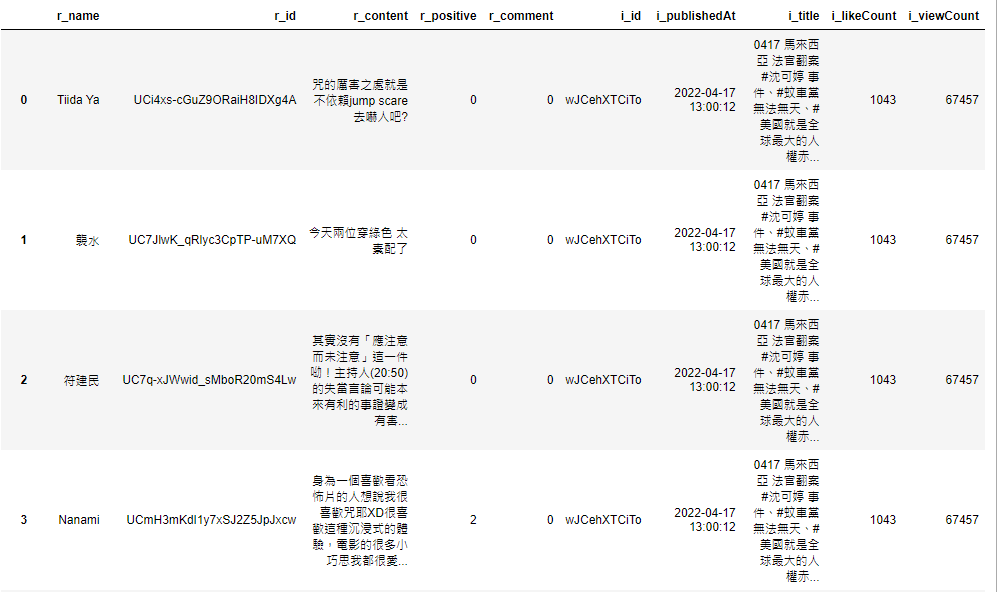

# **Transform simple chinese to traditional chinese**

In [ ]:
def data_filter(content):
  #remove url
  result=[]
  html=content.strip()
  html=html.strip("\n")  
  parse=HTMLParser()

  parse.handle_data=result.append

  parse.feed(html)
  parse.close()
  content = "".join(result)
  #去url
  r1 = '''http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'''
  content = re.sub(r1, '', content)
  return content

cc = OpenCC('s2twp')
c_df['r_content'] = c_df['r_content'].map(lambda x : cc.convert(x).replace('\n',''))
c_df['r_content'] = c_df['r_content'].map(lambda x : data_filter(x))
c_df['i_publishedAt'] = c_df['i_publishedAt'].map(lambda x : str(x)[:10])
c_df.dropna()

In [ ]:
# z = input('name')
path = '/your_path/data_name.csv'
c_df.to_csv(path_or_buf=path, index=False)